In [41]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

In [43]:
subjects = [1, 2]  # Using 2 subjects
runs = [6, 10, 14]  # Motor imagery: hands vs feet
data_path = "/home/student/Advance-Machine-Learning/Mini_Project/datasets"
# Load files
raw_fnames = eegbci.load_data(subjects, runs, path=data_path)


In [46]:
# Read all EDF files and combine them
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

raw.rename_channels(lambda x: x.strip('.')) # Clean up channel names (remove dots)

print(f"Data loaded!")
print(f"Duration: {raw.times[-1]:.1f} seconds")
print(f"Channels: {raw.n_times} samples, {len(raw.ch_names)} channels")
print(f"Sampling rate: {raw.info['sfreq']} Hz")

Extracting EDF parameters from /home/student/Advance-Machine-Learning/Mini_Project/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/student/Advance-Machine-Learning/Mini_Project/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/student/Advance-Machine-Learning/Mini_Project/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/student/Advance-Machine-Learning/Mini_Project/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S0

In [47]:
# Set Electrode Positions - This tells MNE where each electrode is on the scalp

eegbci.standardize(raw)  # Standardize channel names
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)

print("Electrode positions set")
print(f"Channel names: {raw.ch_names[:10]}...")  # Show first 10

Electrode positions set
Channel names: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1']...


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


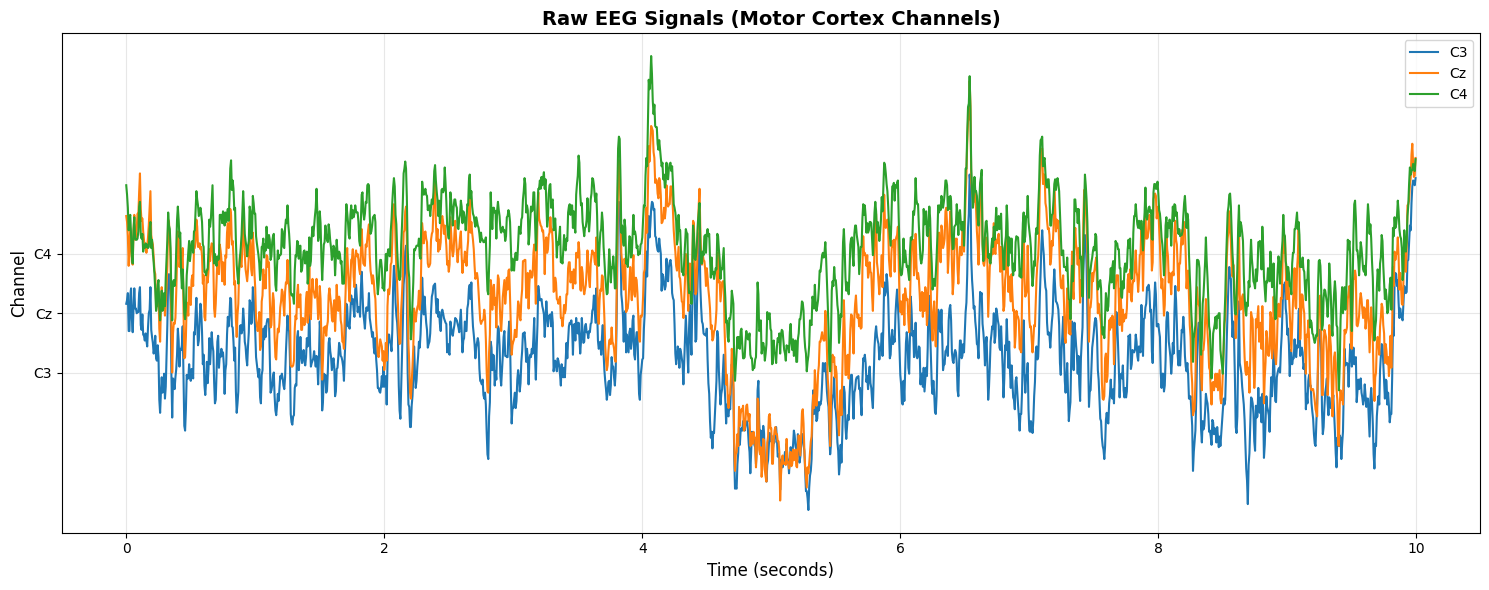

This shows the raw brain signals - notice they're quite noisy!


In [ ]:
duration = 10  # seconds
channels_to_plot = ['C3', 'Cz', 'C4']  # Motor cortex channels

data, times = raw.copy().pick_channels(channels_to_plot).get_data(return_times=True)
data = data[:, :int(duration * raw.info['sfreq'])]
times = times[:int(duration * raw.info['sfreq'])]

# Plot
plt.figure(figsize=(15, 6))
for i, ch in enumerate(channels_to_plot):
    plt.plot(times, data[i] * 1e6 + i * 50, label=ch)  # Convert to µV

plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Channel', fontsize=12)
plt.title('Raw EEG Signals (Motor Cortex Channels)', fontsize=14, fontweight='bold')
plt.yticks([0, 50, 100], channels_to_plot)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/home/student/Advance-Machine-Learning/.venv/lib/python3.13/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/tmp/ipykernel_349379/951811852.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


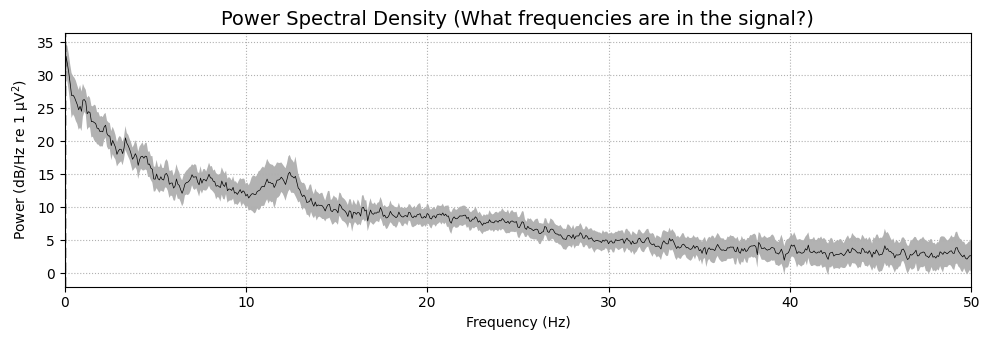

The peaks show dominant frequencies in the brain signals
For motor imagery, we care about 8-30 Hz (mu and beta bands)


In [51]:
#Visualize Power Spectral
#This show which frequencies are present in the signal

fig = raw.compute_psd(fmax=50).plot(picks='eeg', average=True)
plt.title('Power Spectral Density (What frequencies are in the signal?)', fontsize=14)
plt.tight_layout()
plt.show()
print("The peaks show dominant frequencies in the brain signals")
print("For motor imagery, we care about 8-30 Hz (mu and beta bands)")

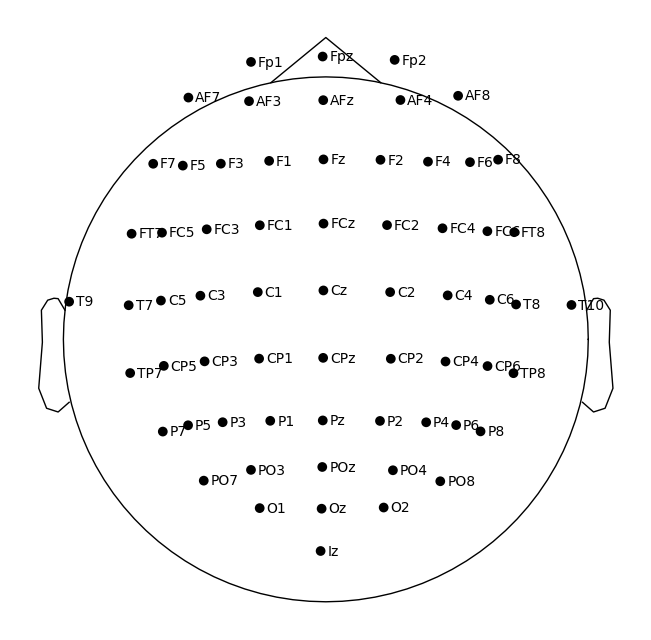

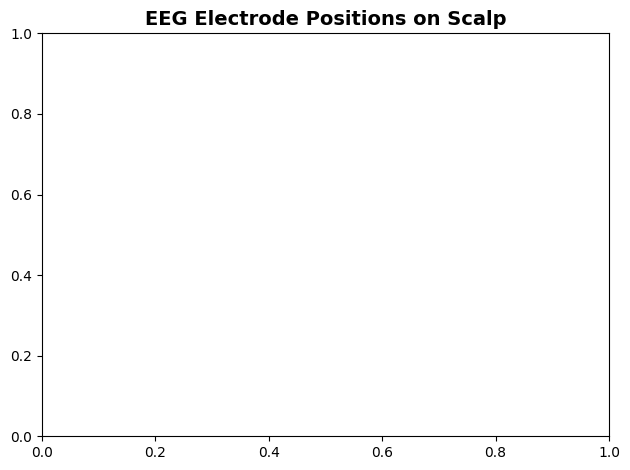

C3 = Left motor cortex, C4 = Right motor cortex, Cz = Center


In [52]:
# Visualize Electrode Locations
# Let's see where the electrodes are positioned on the head

fig = raw.plot_sensors(show_names=True)
plt.title('EEG Electrode Positions on Scalp', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("C3 = Left motor cortex, C4 = Right motor cortex, Cz = Center")

In [53]:
# Check Events (What tasks were performed?)
# Extract the event markers from the data

events, event_dict = mne.events_from_annotations(raw)

print(f"Found {len(events)} events")
print(f"Event types: {event_dict}")
print("\nEvent codes:")
print("T0 = Rest")
print("T1 = Left/Both fists imagery")
print("T2 = Right/Both feet imagery")

# Count events
for event_name, event_code in event_dict.items():
    count = np.sum(events[:, 2] == event_code)
    print(f"  {event_name}: {count} times")

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Found 180 events
Event types: {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}

Event codes:
T0 = Rest
T1 = Left/Both fists imagery
T2 = Right/Both feet imagery
  T0: 90 times
  T1: 45 times
  T2: 45 times


In [54]:
# Filter to focus on motor imagery frequencies (7-35 Hz)

print("Before filtering:")
print(f"  Highpass: {raw.info['highpass']} Hz")
print(f"  Lowpass: {raw.info['lowpass']} Hz")

# Make a copy so we can compare
raw_filtered = raw.copy()

# Apply bandpass filter (keeps only 7-35 Hz)
raw_filtered.filter(7., 35., fir_design='firwin')

print("\nAfter filtering:")
print(f"  Highpass: {raw_filtered.info['highpass']} Hz")
print(f"  Lowpass: {raw_filtered.info['lowpass']} Hz")
print("\n✓ Filtering complete - signal is now cleaner!")

Before filtering:
  Highpass: 0.0 Hz
  Lowpass: 80.0 Hz
Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 265 samples (1.656 s)




After filtering:
  Highpass: 7.0 Hz
  Lowpass: 35.0 Hz

✓ Filtering complete - signal is now cleaner!


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


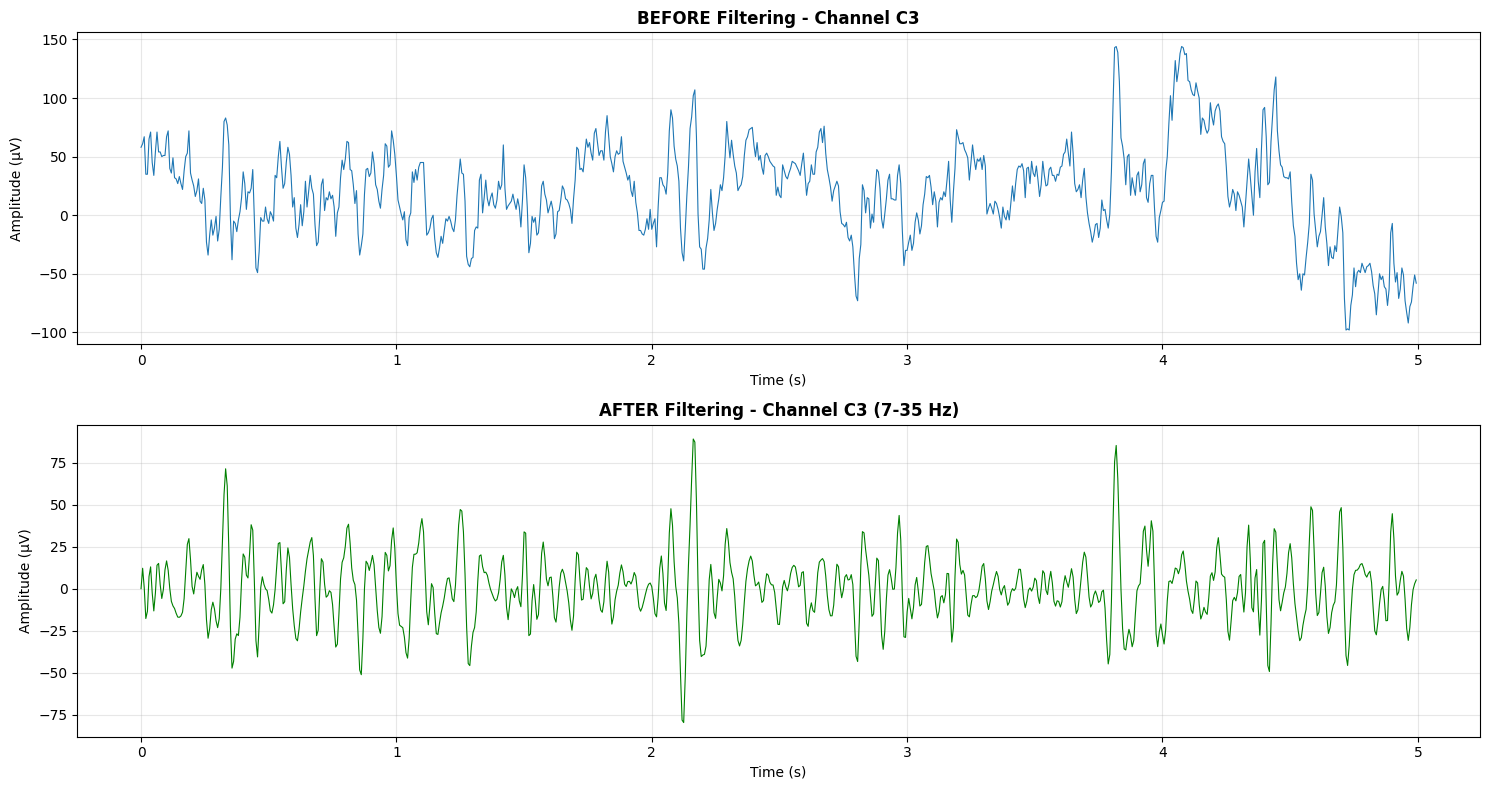

Notice: Filtered signal is smoother - high-frequency noise is removed!


In [55]:
# Compare Before and After Filtering

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Pick one channel
ch_name = 'C3'
duration = 5
n_samples = int(duration * raw.info['sfreq'])

# Get data
data_raw, times = raw.copy().pick_channels([ch_name]).get_data(return_times=True)
data_filtered, _ = raw_filtered.copy().pick_channels([ch_name]).get_data(return_times=True)

# Plot raw
ax1.plot(times[:n_samples], data_raw[0, :n_samples] * 1e6, linewidth=0.8)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (µV)')
ax1.set_title(f'BEFORE Filtering - Channel {ch_name}', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot filtered
ax2.plot(times[:n_samples], data_filtered[0, :n_samples] * 1e6, 
         linewidth=0.8, color='green')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude (µV)')
ax2.set_title(f'AFTER Filtering - Channel {ch_name} (7-35 Hz)', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice: Filtered signal is smoother - high-frequency noise is removed!")

In [56]:
#Create Epochs (Cut data into trials)
# Each epoch = one motor imagery trial

event_id = {'T1': 2, 'T2': 3}  # T1=hands/fists, T2=feet
tmin, tmax = -1., 4.  # From 1s before to 4s after event

epochs = mne.Epochs(raw_filtered, events, event_id, 
                    tmin, tmax, 
                    baseline=(None, 0),  # Baseline correction
                    preload=True)

print(f"Created {len(epochs)} epochs")
print(f"Each epoch is {tmax - tmin} seconds long")
print(f"\nT1 (hands/fists): {len(epochs['T1'])} epochs")
print(f"T2 (feet): {len(epochs['T2'])} epochs")

Not setting metadata
90 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 801 original time points ...
0 bad epochs dropped
Created 90 epochs
Each epoch is 5.0 seconds long

T1 (hands/fists): 45 epochs
T2 (feet): 45 epochs


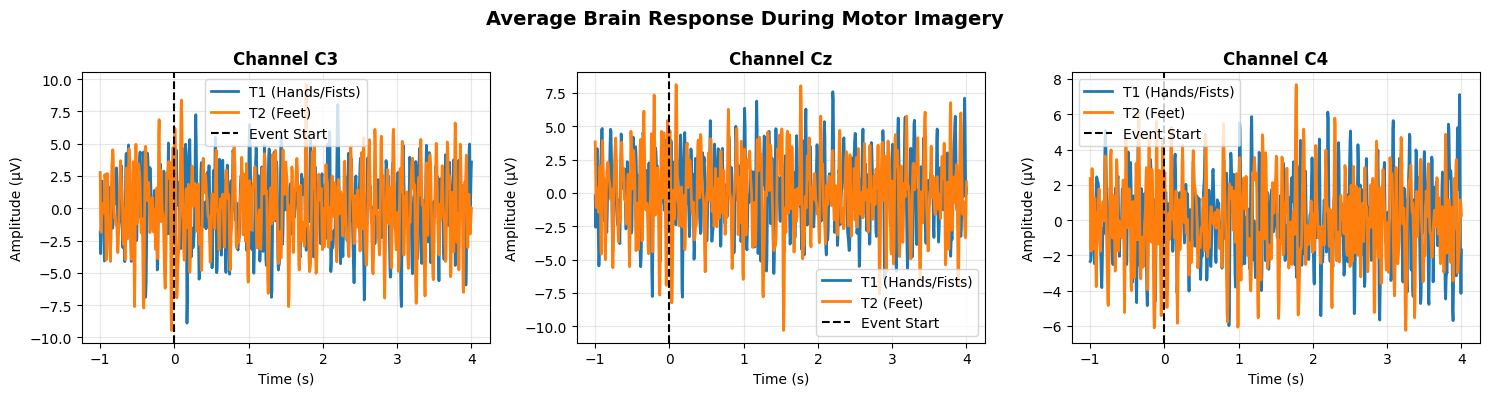

These show how brain activity changes during motor imagery
Differences between T1 and T2 show we can distinguish hand vs foot imagery!


In [57]:
#    Visualize Average Brain Response
# Average all trials together to see the pattern

# Get average response for each condition
evoked_T1 = epochs['T1'].average()  # Hands/fists
evoked_T2 = epochs['T2'].average()  # Feet

# Pick motor cortex channels
picks = ['C3', 'Cz', 'C4']

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, ch in enumerate(picks):
    # Extract data for this channel
    ch_idx = evoked_T1.ch_names.index(ch)
    
    # Plot both conditions
    axes[i].plot(evoked_T1.times, evoked_T1.data[ch_idx] * 1e6, 
                 label='T1 (Hands/Fists)', linewidth=2)
    axes[i].plot(evoked_T2.times, evoked_T2.data[ch_idx] * 1e6, 
                 label='T2 (Feet)', linewidth=2)
    
    axes[i].axvline(0, color='black', linestyle='--', label='Event Start')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Amplitude (µV)')
    axes[i].set_title(f'Channel {ch}', fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Average Brain Response During Motor Imagery', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("These show how brain activity changes during motor imagery")
print("Differences between T1 and T2 show we can distinguish hand vs foot imagery!")

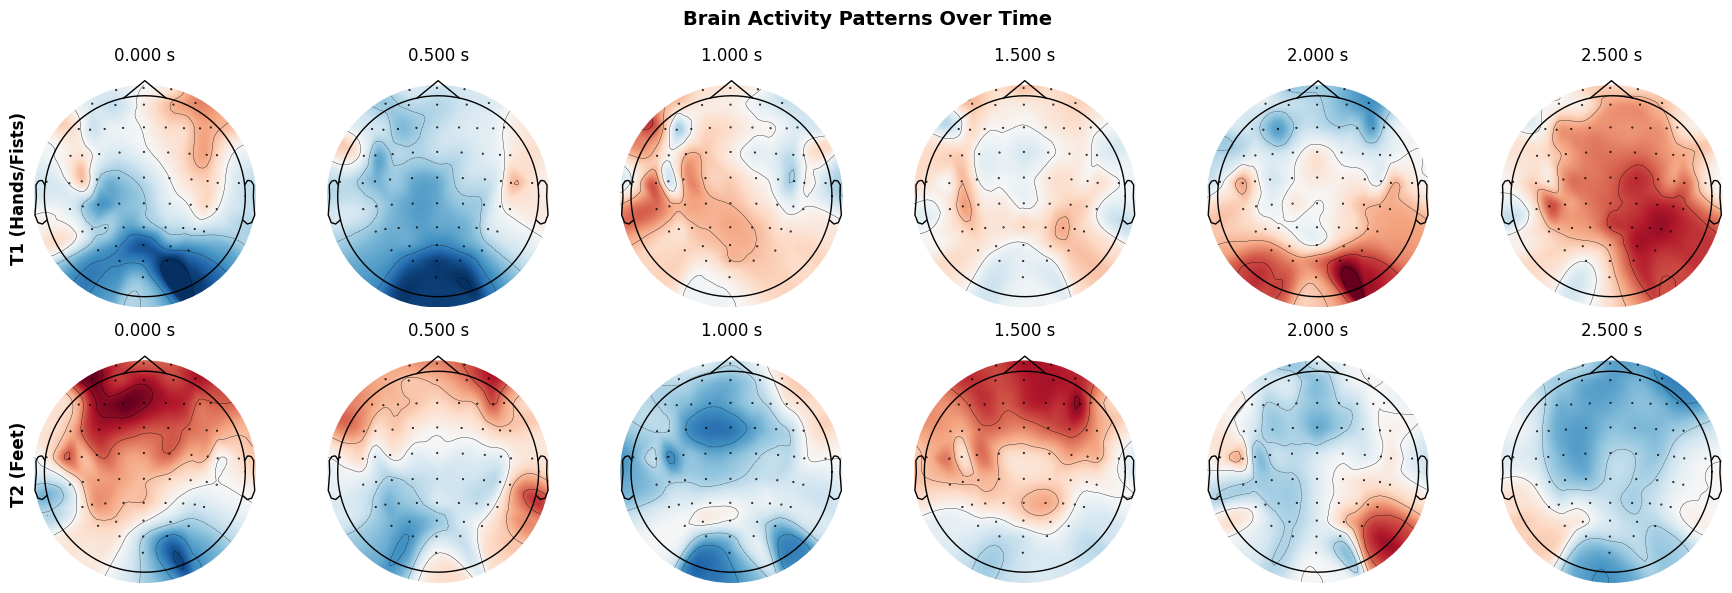

These maps show WHERE on the scalp the brain is most active
Red = high activity, Blue = low activity


In [61]:
#Create Topographic Maps
# Show brain activity on scalp at different time points

times_to_plot = [0, 0.5, 1.0, 1.5, 2.0, 2.5]

fig, axes = plt.subplots(2, len(times_to_plot), figsize=(18, 6))

# Plot T1 (hands/fists)
evoked_T1.plot_topomap(times=times_to_plot, axes=axes[0], 
                       show=False, colorbar=False, 
                       time_unit='s')
axes[0, 0].set_ylabel('T1 (Hands/Fists)', fontsize=12, fontweight='bold')

# Plot T2 (feet)
evoked_T2.plot_topomap(times=times_to_plot, axes=axes[1], 
                       show=False, colorbar=False, 
                       time_unit='s')
axes[1, 0].set_ylabel('T2 (Feet)', fontsize=12, fontweight='bold')

plt.suptitle('Brain Activity Patterns Over Time', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("These maps show WHERE on the scalp the brain is most active")
print("Red = high activity, Blue = low activity")

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


Applying baseline correction (mode: percent)


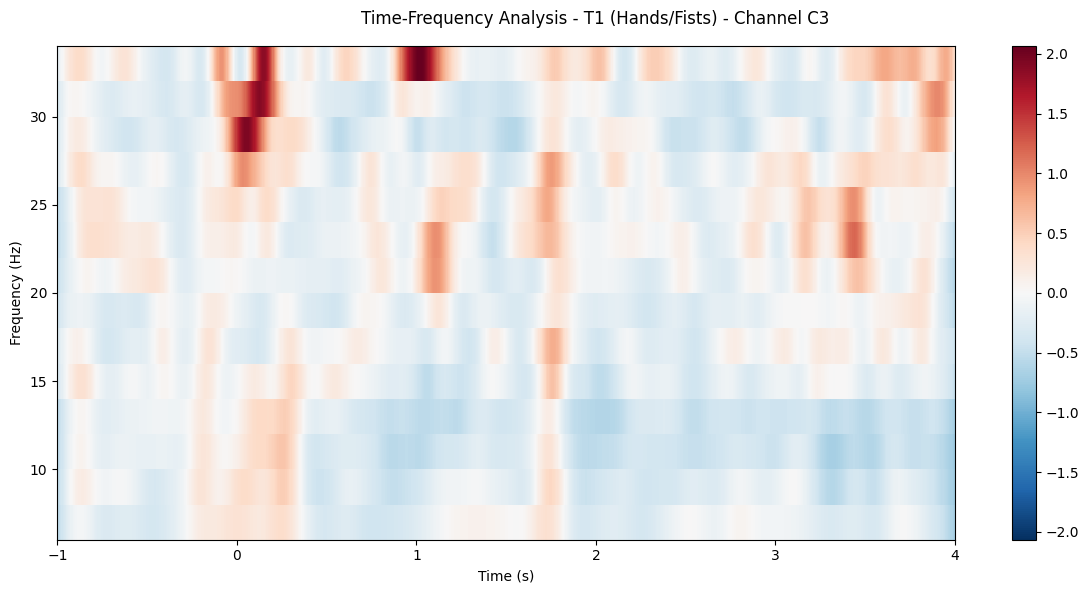

This shows when different brain frequencies are active
Look for blue areas = suppression of mu/beta rhythms during motor imagery


In [62]:
#Time-Frequency Analysis
# See how different frequencies change over time

from mne.time_frequency import tfr_morlet

# Define frequencies to analyze
freqs = np.arange(7, 35, 2)  # 7-35 Hz in steps of 2
n_cycles = freqs / 2.  # Number of cycles for each frequency

# Compute time-frequency for T1 (hands/fists)
power_T1 = tfr_morlet(epochs['T1'], freqs=freqs, n_cycles=n_cycles, 
                      return_itc=False, average=True)

# Plot for channel C3
fig, ax = plt.subplots(figsize=(12, 6))
power_T1.plot(picks=['C3'], baseline=(-0.5, 0), mode='percent',
              title='Time-Frequency Analysis - T1 (Hands/Fists) - Channel C3',
              show=False, axes=ax)
plt.tight_layout()
plt.show()

print("This shows when different brain frequencies are active")
print("Look for blue areas = suppression of mu/beta rhythms during motor imagery")

In [63]:
print(f"  • Subjects: {subjects}")
print(f"  • Duration: {raw.times[-1]:.1f} seconds")
print(f"  • Channels: {len(raw.ch_names)}")
print(f"  • Sampling rate: {raw.info['sfreq']} Hz")

print(f"  • Filtering: {raw_filtered.info['highpass']}-{raw_filtered.info['lowpass']} Hz")

print(f"  • Total epochs: {len(epochs)}")
print(f"  • T1 (Hands/Fists): {len(epochs['T1'])}")
print(f"  • T2 (Feet): {len(epochs['T2'])}")
print(f"  • Epoch length: {tmax - tmin} seconds")

print("="*60)

  • Subjects: [1, 2]
  • Duration: 744.0 seconds
  • Channels: 64
  • Sampling rate: 160.0 Hz
  • Filtering: 7.0-35.0 Hz
  • Total epochs: 90
  • T1 (Hands/Fists): 45
  • T2 (Feet): 45
  • Epoch length: 5.0 seconds


In [64]:
epochs.save('preprocessed_epochs-epo.fif', overwrite=True)
# Save evoked responses
evoked_T1.save('evoked_T1-ave.fif', overwrite=True)
evoked_T2.save('evoked_T2-ave.fif', overwrite=True)